In [83]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [84]:
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor

# Import Nanophotonics Data

In [108]:
fomsx = torch.Tensor(loadmat('FOMs_x.mat', mat_dtype=True)['RVs_rnd'])
fomsy = torch.Tensor(loadmat('FOMs_y.mat', mat_dtype=True)['FOMs'])

# F0 Fidelity

In [109]:
f0 = torch.cat((fomsx[:,0:5], fomsy[:,0:1]), 1)
f0 = f0[torch.randperm(f0.size()[0])]
data = f0
#if not os.path.isfile('elevators.mat'):
#    print('Downloading \'elevators\' UCI dataset...')
#    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', 'elevators.mat')

#data = torch.Tensor(loadmat('elevators.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

# Use the first 80% of the data for training, and the last 20% for testing.
train_n = int(floor(0.8*len(X)))

train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

In [110]:
data_dim = train_x.size(-1)

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 2))

feature_extractor = LargeFeatureExtractor()

In [111]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [112]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

In [113]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 60
def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

# See dkl_mnist.ipynb for explanation of this flag
with gpytorch.settings.use_toeplitz(True):
    %time train()

Iter 1/60 - Loss: 316070.625
Iter 2/60 - Loss: 309448.188
Iter 3/60 - Loss: 308253.219
Iter 4/60 - Loss: 303485.375
Iter 5/60 - Loss: 299088.781
Iter 6/60 - Loss: 295577.312
Iter 7/60 - Loss: 292145.844
Iter 8/60 - Loss: 288821.594
Iter 9/60 - Loss: 286085.781
Iter 10/60 - Loss: 283105.406
Iter 11/60 - Loss: 279701.938
Iter 12/60 - Loss: 276345.469
Iter 13/60 - Loss: 273538.188
Iter 14/60 - Loss: 270164.844
Iter 15/60 - Loss: 266928.844
Iter 16/60 - Loss: 263319.469
Iter 17/60 - Loss: 260412.109
Iter 18/60 - Loss: 257992.734
Iter 19/60 - Loss: 254647.266
Iter 20/60 - Loss: 251479.234
Iter 21/60 - Loss: 248186.828
Iter 22/60 - Loss: 247364.766
Iter 23/60 - Loss: 250328.406
Iter 24/60 - Loss: 248557.516
Iter 25/60 - Loss: 245838.516
Iter 26/60 - Loss: 242942.141
Iter 27/60 - Loss: 238439.234
Iter 28/60 - Loss: 235690.781
Iter 29/60 - Loss: 232020.172
Iter 30/60 - Loss: 228226.219
Iter 31/60 - Loss: 225700.219
Iter 32/60 - Loss: 222669.406
Iter 33/60 - Loss: 220501.422
Iter 34/60 - Loss: 

In [114]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x)

In [116]:
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    train_preds = model(train_x)
print('Train MAE: {}'.format(torch.mean(torch.abs(train_preds.mean - train_y))))

Train MAE: 426.04217529296875


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:247: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


In [115]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 534.7948608398438


# F1 Fidelity

In [95]:
f1 = torch.cat((fomsx[:,0:5], fomsy[:,1:2]), 1)
f1 = f1[torch.randperm(f0.size()[0])]
data = f1

X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

# Use the first 80% of the data for training, and the last 20% for testing.
train_n = int(floor(0.8*len(X)))

train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

In [96]:
data_dim = train_x.size(-1)

feature_extractor = LargeFeatureExtractor()

In [97]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

In [98]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 60
def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

# See dkl_mnist.ipynb for explanation of this flag
with gpytorch.settings.use_toeplitz(True):
    %time train()

Iter 1/60 - Loss: 78329.734
Iter 2/60 - Loss: 75709.570
Iter 3/60 - Loss: 71425.562
Iter 4/60 - Loss: 69685.180
Iter 5/60 - Loss: 67653.703
Iter 6/60 - Loss: 66153.445
Iter 7/60 - Loss: 64489.352
Iter 8/60 - Loss: 62887.633
Iter 9/60 - Loss: 60827.512
Iter 10/60 - Loss: 59943.648
Iter 11/60 - Loss: 58588.652
Iter 12/60 - Loss: 57837.777
Iter 13/60 - Loss: 55990.848
Iter 14/60 - Loss: 55376.008
Iter 15/60 - Loss: 54486.082
Iter 16/60 - Loss: 52747.555
Iter 17/60 - Loss: 51616.535
Iter 18/60 - Loss: 50745.480
Iter 19/60 - Loss: 49326.977
Iter 20/60 - Loss: 48739.941
Iter 21/60 - Loss: 47984.977
Iter 22/60 - Loss: 46625.273
Iter 23/60 - Loss: 45830.047
Iter 24/60 - Loss: 45367.789
Iter 25/60 - Loss: 45465.441
Iter 26/60 - Loss: 43923.406
Iter 27/60 - Loss: 43364.781
Iter 28/60 - Loss: 42830.148
Iter 29/60 - Loss: 41213.836
Iter 30/60 - Loss: 40647.664
Iter 31/60 - Loss: 40651.199
Iter 32/60 - Loss: 40183.098
Iter 33/60 - Loss: 40771.688
Iter 34/60 - Loss: 39745.715
Iter 35/60 - Loss: 3985

In [99]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x)

In [100]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 151.2612762451172


# F2 Fidelity

In [118]:
f2.size()

torch.Size([4983, 6])

In [101]:
f2 = torch.cat((fomsx[:,0:5], fomsy[:,2:3]), 1)
f2 = f2[torch.randperm(f0.size()[0])]
data = f2

X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

train_n = int(floor(0.8*len(X)))

train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

In [102]:
data_dim = train_x.size(-1)

feature_extractor = LargeFeatureExtractor()

In [103]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

In [104]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 60
def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

# See dkl_mnist.ipynb for explanation of this flag
with gpytorch.settings.use_toeplitz(True):
    %time train()

Iter 1/60 - Loss: 140728.109
Iter 2/60 - Loss: 135678.375
Iter 3/60 - Loss: 128216.062
Iter 4/60 - Loss: 125743.219
Iter 5/60 - Loss: 120583.156
Iter 6/60 - Loss: 118685.500
Iter 7/60 - Loss: 115023.516
Iter 8/60 - Loss: 111105.977
Iter 9/60 - Loss: 107162.234
Iter 10/60 - Loss: 103565.539
Iter 11/60 - Loss: 100971.406
Iter 12/60 - Loss: 99462.922
Iter 13/60 - Loss: 97114.367
Iter 14/60 - Loss: 94522.398
Iter 15/60 - Loss: 92956.523
Iter 16/60 - Loss: 91233.789
Iter 17/60 - Loss: 88963.742
Iter 18/60 - Loss: 87190.609
Iter 19/60 - Loss: 85849.875
Iter 20/60 - Loss: 84115.234
Iter 21/60 - Loss: 82339.727
Iter 22/60 - Loss: 81023.695
Iter 23/60 - Loss: 79612.508
Iter 24/60 - Loss: 78161.945
Iter 25/60 - Loss: 76797.984
Iter 26/60 - Loss: 75512.547
Iter 27/60 - Loss: 73915.328
Iter 28/60 - Loss: 72722.336
Iter 29/60 - Loss: 72049.648
Iter 30/60 - Loss: 72479.477
Iter 31/60 - Loss: 72830.672
Iter 32/60 - Loss: 72102.078
Iter 33/60 - Loss: 70202.242
Iter 34/60 - Loss: 68431.594
Iter 35/60 -

In [105]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x)

In [106]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 223.6408233642578


# Regression with regular GP with squared exponential kernel

In [119]:
%load_ext autoreload
%autoreload 2

In [133]:
f2 = torch.cat((fomsx[:,0:5], fomsy[:,2:3]), 1)
f2 = f2[torch.randperm(f0.size()[0])]
data = f2

X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

train_n = int(floor(0.8*len(X)))

train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

In [134]:
X.size(), y.size(), train_x.size(), train_y.size(), test_x.size(), test_y.size()

(torch.Size([4983, 5]),
 torch.Size([4983]),
 torch.Size([3986, 5]),
 torch.Size([3986]),
 torch.Size([997, 5]),
 torch.Size([997]))

In [135]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [127]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 96036.086   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 87546.477   lengthscale: 0.644   noise: 0.744
Iter 3/50 - Loss: 79903.406   lengthscale: 0.598   noise: 0.798
Iter 4/50 - Loss: 73060.273   lengthscale: 0.555   noise: 0.853
Iter 5/50 - Loss: 66970.258   lengthscale: 0.514   noise: 0.910
Iter 6/50 - Loss: 61604.480   lengthscale: 0.476   noise: 0.969
Iter 7/50 - Loss: 56951.957   lengthscale: 0.440   noise: 1.028
Iter 8/50 - Loss: 53007.867   lengthscale: 0.408   noise: 1.087
Iter 9/50 - Loss: 49765.117   lengthscale: 0.379   noise: 1.147
Iter 10/50 - Loss: 47176.375   lengthscale: 0.354   noise: 1.206
Iter 11/50 - Loss: 45123.332   lengthscale: 0.334   noise: 1.265
Iter 12/50 - Loss: 43401.844   lengthscale: 0.319   noise: 1.323
Iter 13/50 - Loss: 41793.348   lengthscale: 0.309   noise: 1.379
Iter 14/50 - Loss: 40157.277   lengthscale: 0.304   noise: 1.435
Iter 15/50 - Loss: 38466.930   lengthscale: 0.303   noise: 1.489
Iter 16/50 - Loss: 36773.918   len

In [136]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 5 and 1 in dimension 1 at /Users/distiller/project/conda/conda-bld/pytorch_1570710797334/work/aten/src/TH/generic/THTensor.cpp:689

NameError: name 'observed_pred' is not defined

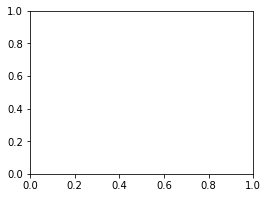

In [129]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])